In [1]:
!pip install mnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# The full neural network code!
###############################
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense
#from keras.utils import to_categorical


from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization

from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.datasets import mnist
from keras.models import load_model

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, plot_confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  # This is added back by InteractiveShellApp.init_path()


## Попробуем с использованием Keras Tuner

использовал тот же код что с домашки2, добавив dropout и нормализацию в архитектуру модели и уменьшив число перебираемых гиперпараметров

In [3]:
!pip install -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# по новой загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train / 255 
x_test = x_test / 255 
y_train = utils.to_categorical(y_train, 10)
y_test = utils.to_categorical(y_test, 10)





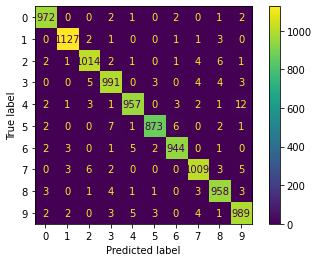

accuracy: 0.9834
Метрика после глубокого тюнинга модели, accuracy выросла до: 0.9834


In [5]:
# # Тюнинг занял длительное время, поэтому сохранил уже оттюнингованную модель

model_tune_load = load_model('model_tune_add_drop_norm_.h5')

predictions = model_tune_load.predict(x_test)

test_labels = np.argmax(y_test, axis=1)
predictions_label = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_labels, predictions_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


# так как класы в таргете примерно сбалансированы можно применить и accuracy_score
acc = accuracy_score(test_labels, predictions_label)
print(f'accuracy: {acc}')


print(f'Метрика после глубокого тюнинга модели, accuracy выросла до: {acc}')
# Удалось улучщить за счет более сложной архитектуры модели (дропаут и нормализацию)

In [ ]:
# взял готовый код 
# https://colab.research.google.com/drive/1m_8puwuGg9C7LWChv4YvZEmAlocGC7nG

In [ ]:
def build_model_tune(hp):
    model = Sequential()
    activation_choice = hp.Choice('activation', values=['relu', 'elu'])    
    model.add(Dense(units=hp.Int('units_input',   
                                   min_value=256,    
                                   max_value=512,   
                                   step=64),
                    input_dim=784,
                    activation=activation_choice)),
    keras.layers.Dropout(0.15),
    model.add(Dense(units=hp.Int('units_hidden',        
                                   min_value=128,   
                                   max_value=600,   
                                   step=32),
                    activation=activation_choice)) 
    keras.layers.BatchNormalization(),  
    model.add(Dense(10, activation='softmax'))
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam','rmsprop']),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
# cоздаем tuner
tuner = RandomSearch(
    build_model_tune,            # функция создания модели
    objective='val_accuracy',    # метрика, которую нужно оптимизировать - 
                                 # доля правильных ответов на проверочном наборе данных
    max_trials=20,               # максимальное количество запусков обучения 
    directory='test_directory_3'   # каталог, куда сохраняются обученные сети  
    )

In [ ]:
tuner.search_space_summary()

In [ ]:
%%time
tuner.search(x_train,                  # Данные для обучения
             y_train,                  # Правильные ответы
             batch_size=256,           # Размер мини-выборки
             epochs=20,                # Количество эпох обучения 
             validation_split=0.2,     # Часть данных, которая будет использоваться для проверки
             )

In [ ]:
tuner.results_summary()

In [ ]:
# лучшая модель

model_tune = tuner.get_best_models(num_models=1)

In [ ]:
test_labels = np.argmax(y_test, axis=1)
predictions_label = np.argmax(predictions, axis=1)


cm = confusion_matrix(test_labels, predictions_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


# так как класы в таргете примерно сбалансированы можно применить и accuracy_score
acc = accuracy_score(test_labels, predictions_label)
print(f'accuracy: {acc}')


print(f'Метрика после глубокого тюнинга модели, accuracy выросла до: {acc}')
# Удалось улучщить за счет более сложной архитектуры модели (использоване дропаута и нормализации)

In [ ]:
model_tune[0].summary()

# Save the model to disk.
model_tune[0].save('model_tune_add_drop_norm_.h5')
